# NYC Taxi trip duration

Demo of Bayesian optimization. The features and model are inspired by https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367, but was simplified to illustrate BayesOpt instead.

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
train = pd.read_csv('input/nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('input/nyc-taxi-trip-duration/test.csv')

In [4]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

# Convert trip duration into the log domain, and use RMSE to train the model
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

Trip_duration and datetimes are ok.


## Feature Extraction

In [5]:
# PCA
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [6]:
# Distances
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [7]:
# Datetime
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

In [8]:
# Speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

In [9]:
# Clustering
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [10]:
# Temporal and geospatial
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)
    
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

In [11]:
# OSRM features
fr1 = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 59 features.


In [12]:
# Sanity check
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
43,avg_speed_h_center_lat_bin_center_long_bin,0.002543
21,pickup_dt,0.002648
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872


In [13]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
39,log_trip_duration_gby_pickup_cluster,0.000,0.000,0.000
34,avg_speed_h_gby_pickup_week_hour,0.000,0.000,0.000
18,pickup_hour_weekofyear,0.000,0.000,0.000
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.104,0.106,0.002
52,cnt_pickup_cluster_dropoff_cluster,0.104,0.106,0.002


In [14]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

## Modeling

In [14]:
# Try different parameters! My favorite is random search :)
#xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
#            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#            'eval_metric': 'rmse', 'objective': 'reg:linear'}

xgb_pars = dict(base_score=0.94442985032389859, booster='gbtree',
                colsample_bylevel=0.98585604769455193,
                colsample_bytree=0.92445691213304193, gamma=0.072172952116487318,
                learning_rate=0.047960999030042195, max_delta_step=6,
                max_depth=11, min_child_weight=137, n_estimators=44,
                reg_alpha=0.11089082081183133, reg_lambda=0.43933650186577011,
                scale_pos_weight=0.84464184630556982, subsample=0.94788179783675974,
                eval_metric='rmse', objective='reg:linear')
            
model = xgb.train(xgb_pars, dtrain, num_boost_round=60, evals=watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:5.31831	valid-rmse:5.31922
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:3.2713	valid-rmse:3.27278
[20]	train-rmse:2.02513	valid-rmse:2.02761
[30]	train-rmse:1.2756	valid-rmse:1.27981
[40]	train-rmse:0.835676	valid-rmse:0.842571
[50]	train-rmse:0.590331	valid-rmse:0.600783
[59]	train-rmse:0.473362	valid-rmse:0.48711
Modeling RMSLE 0.48711


In [15]:
yv

array([ 7.36137543,  6.66185474,  5.73009978, ...,  5.7170277 ,
        5.50938834,  6.99576616])

---

# Hyper-parameter Optimization

XGBoost has [many parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md), but in practice we should
only tune a managable number of hyper-parameters. In this section, we will tune the following:

- learning_rate: [0.001, 0.4]
- gamma: (0, 3]
- subsample: (0, 1]
- colsample_bytree: (0, 1]
- reg_lambda: (0, 1]

Those are all continuous, because some optimizers only accept continuous variables.

In [16]:
from hyper_optimizer import Parameter, HyperBaseEstimator

class XGBoostEstimator(HyperBaseEstimator):
    def __init__(self, learning_rate=0.1, gamma=0, subsample=1, colsample_bytree=1, reg_lambda=1):
        super(XGBoostEstimator, self).__init__(learning_rate=learning_rate, gamma=gamma, subsample=subsample, 
                                               colsample_bytree=colsample_bytree, reg_lambda=reg_lambda)
        self.model_ = None
        
    def predict(self, X, y=None):
        import xgboost as xgb
        return self.model_.predict(xgb.DMatrix(X, label=y))

    def fit(self, X, y=None):
        import xgboost as xgb
        dtrain = xgb.DMatrix(X, label=y)
        watchlist = [(dtrain, 'train')]

        xgb_pars = dict(learning_rate=self.learning_rate, gamma=self.gamma, subsample=self.subsample,
                        colsample_bytree=self.colsample_bytree, reg_lambda=self.reg_lambda,
                        base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        max_delta_step=0, max_depth=18, min_child_weight=1, 
                        n_estimators=180, reg_alpha=0, scale_pos_weight=1, 
                        n_jobs=2, eval_metric='rmse', objective='reg:linear', random_state=42, missing=None)
            
        self.model_ = xgb.train(xgb_pars, dtrain, num_boost_round=100, evals=watchlist, 
                                early_stopping_rounds=50, maximize=False, verbose_eval=50)

    def score(self, X, y=None):
        # the library will maximize the return value of this function,
        # so we are gonna return the negated score of the regressor
        from sklearn.metrics import mean_squared_error
        import math
        y_pred = self.predict(X, y)
        return -math.sqrt(mean_squared_error(y_pred, y))
    
params = [Parameter('learning_rate', Parameter.DOUBLE, min_bound=0.001, max_bound=0.4),
          Parameter('gamma', Parameter.DOUBLE, min_bound=0.0, max_bound=3.0),
          Parameter('subsample', Parameter.DOUBLE, min_bound=0.5, max_bound=1.0),
          Parameter('colsample_bytree', Parameter.DOUBLE, min_bound=0.5, max_bound=1.0),
          Parameter('reg_lambda', Parameter.DOUBLE, min_bound=0.0, max_bound=1.0)]

In [17]:
def draw_avg_test_score(history, ylim=(-0.55, -0.35)):
    import matplotlib.pyplot as plt
    y = [e.test_scores[0] for e in history.entries]
    f = plt.figure(figsize=(20, 5))
    plt.plot(range(len(history.entries)), y)
    plt.ylim(ylim[0], ylim[1])
    plt.grid()
    return f

### Random Optimizer

In [16]:
from hyper_optimizer import RandomOptimizer
import time

t = time.time()
random_opt = RandomOptimizer(estimator=XGBoostEstimator(), params=params, max_trials=40, cv=(Xv, yv),
                     random_state=42, n_jobs=20)
random_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

[0]	train-rmse:4.26612
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:3.94572
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:4.02616
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:4.76015
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:5.93148
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:4.78557
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:5.31549
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:5.85817
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:5.78023
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:4.7715
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:3.7715
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:4.03492
Will train until train-rmse hasn't improved in 50 rounds.
[0]	train-rmse:4.49133
Will tr

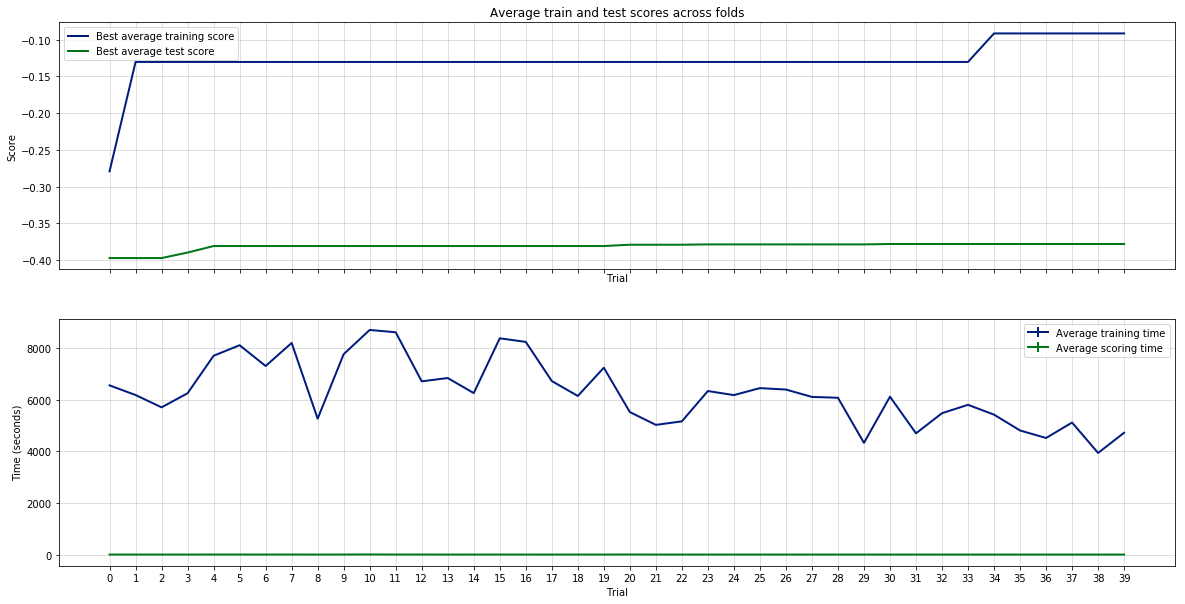

In [17]:
random_opt.history_.plot()

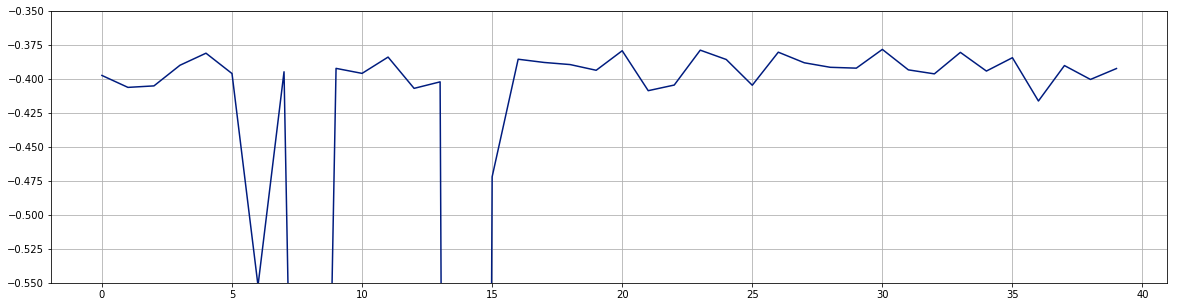

In [21]:
draw_avg_test_score(random_opt.history_)

In [18]:
random_opt.best_test_score_

-0.37826044325161118

In [19]:
random_opt.best_estimator_

XGBoostEstimator(colsample_bytree=0.95413294298332685,
         gamma=0.71868567200091726, learning_rate=0.058813053964398017,
         reg_lambda=0.48945276027756301, subsample=0.99282522705530041)

### scikit-optimize

In [ ]:
from hyper_optimizer import SkOptOptimizer

t = time.time()
skopt_opt = SkOptOptimizer(estimator=XGBoostEstimator(), params=params, max_trials=60, cv=(Xv, yv),
                     random_state=42, n_jobs=20)
skopt_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

### Spearmint 

In [20]:
with open('spearmint_estimator.py', 'w') as f:
    f.write("""
from hyper_optimizer import HyperBaseEstimator

class XGBoostEstimator(HyperBaseEstimator):
    def __init__(self, learning_rate=0.1, gamma=0, subsample=1, colsample_bytree=1, reg_lambda=1):
        super(XGBoostEstimator, self).__init__(learning_rate=learning_rate, gamma=gamma, subsample=subsample, 
                                               colsample_bytree=colsample_bytree, reg_lambda=reg_lambda)
        self.model_ = None
        
    def predict(self, X, y=None):
        import xgboost as xgb
        return self.model_.predict(xgb.DMatrix(X, label=y))

    def fit(self, X, y=None):
        import xgboost as xgb
        dtrain = xgb.DMatrix(X, label=y)
        watchlist = [(dtrain, 'train')]

        xgb_pars = dict(learning_rate=self.learning_rate, gamma=self.gamma, subsample=self.subsample,
                        colsample_bytree=self.colsample_bytree, reg_lambda=self.reg_lambda,
                        base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        max_delta_step=0, max_depth=18, min_child_weight=1, 
                        n_estimators=180, reg_alpha=0, scale_pos_weight=1, 
                        n_jobs=2, eval_metric='rmse', objective='reg:linear', random_state=42, missing=None)
            
        self.model_ = xgb.train(xgb_pars, dtrain, num_boost_round=100, evals=watchlist, 
                                early_stopping_rounds=50, maximize=False, verbose_eval=50)

    def score(self, X, y=None):
        # the library will maximize the return value of this function,
        # so we are gonna return the negated score of the regressor
        from sklearn.metrics import mean_squared_error
        import math
        y_pred = self.predict(X, y)
        return -math.sqrt(mean_squared_error(y_pred, y))
    """)

In [19]:
from hyper_optimizer import SpearmintOptimizer
import spearmint_estimator
import time

t = time.time()
spearmint_opt = SpearmintOptimizer(estimator=spearmint_estimator.XGBoostEstimator, 
                                   params=params, max_trials=60, cv=(Xv, yv),
                                   noisy_likelihood=True, db_address='localhost', expr_name='nyc-taxi-duration',
                                   overwrite_expr=True, polling_time=0, n_jobs=20)
spearmint_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

Experiment directory: /tmp/hyper_optimizerjtt_24f1nyc-taxi-duration
Not running from main.
Not running from main.


Using database at localhost.
/usr/local/lib/python3.5/dist-packages/spearmint/utils/database/mongodb.py:201: DeprecationWarning: last_status() is deprecated
  self.myId = self.db.last_status()['connectionId']


Exception: Could not establish a connection to MongoDB.

In [18]:
spearmint_opt.best_estimator_

XGBoostEstimator(base_score=0.0, booster='gbtree',
         colsample_bylevel=0.6067391613587527, colsample_bytree=1.0,
         gamma=0.0, learning_rate=0.2, max_delta_step=10, max_depth=15,
         min_child_weight=200, n_estimators=158,
         reg_alpha=0.027753741929214894, reg_lambda=1.0,
         scale_pos_weight=3.0, subsample=1.0)

In [20]:
spearmint_opt.best_test_score_

-0.37610434052022879

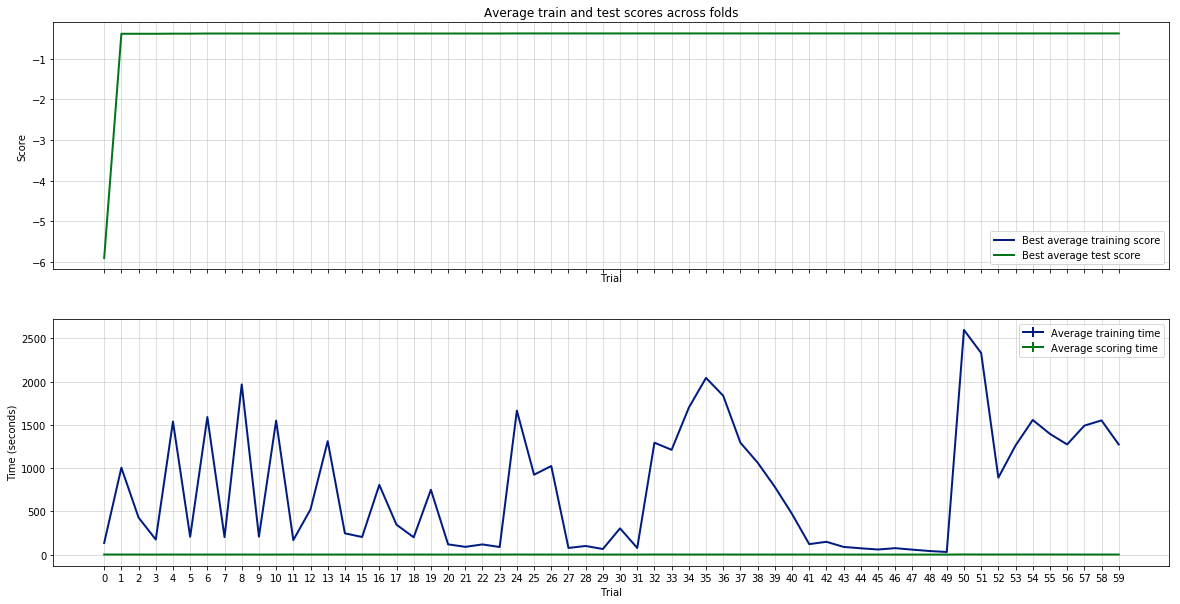

In [19]:
spearmint_opt.history_.plot()

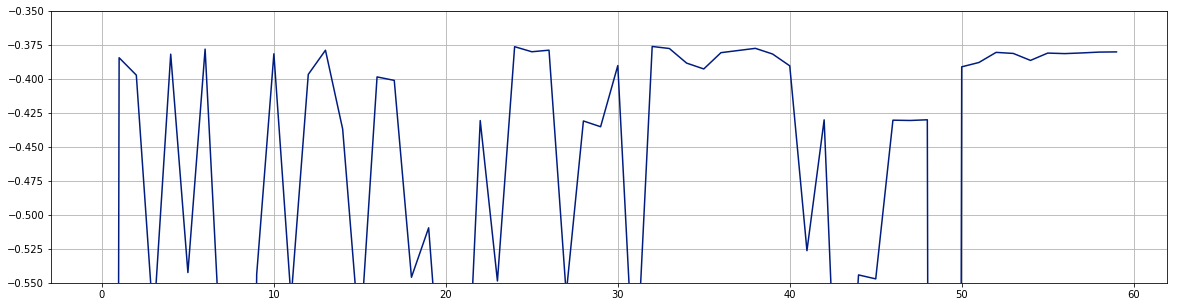

In [41]:
draw_avg_test_score(spearmint_opt.history_)

In [33]:
import pandas as pd

df = pd.DataFrame(data=[dict(**(e.params), avg_test_score=e.test_scores[0],
                            avg_train_sc) for e in spearmint_opt.history_.entries])
df

,avg_test_score,base_score,booster,colsample_bylevel,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,scale_pos_weight,subsample
0,-5.902797,0.000000,gbtree,0.500000,0.500000,0.000000e+00,0.001000,0,1,1,30,0.000000,0.000000,0.300000,0.500000
1,-0.384396,1.000000,gbtree,0.750000,0.750000,5.000000e-02,0.100500,5,8,100,115,0.500000,0.500000,1.650000,0.750000
2,-0.397176,1.500000,gbtree,0.625000,0.625000,7.500000e-02,0.150250,8,4,50,72,0.250000,0.750000,2.325000,0.875000
3,-0.580253,0.500000,gblinear,0.875000,0.875000,2.500000e-02,0.050750,2,12,150,158,0.750000,0.250000,0.975000,0.625000
4,-0.381771,0.750000,dart,0.937500,0.687500,6.250000e-02,0.075625,9,10,75,136,0.875000,0.875000,1.312500,0.687500
5,-0.542470,1.750000,gblinear,0.687500,0.937500,1.250000e-02,0.175125,4,2,175,51,0.375000,0.375000,2.662500,0.937500
6,-0.378060,1.250000,gbtree,0.812500,0.562500,3.750000e-02,0.125375,1,14,25,179,0.625000,0.125000,1.987500,0.812500
7,-0.624905,0.250000,gblinear,0.562500,0.812500,8.750000e-02,0.025875,6,6,125,94,0.125000,0.625000,0.637500,0.562500
8,-1.637032,0.375000,dart,0.968750,0.968750,3.125000e-02,0.013438,7,15,63,190,0.437500,0.937500,2.493750,0.781250
9,-0.543804,1.375000,gblinear,0.718750,0.718750,8.125000e-02,0.112938,2,7,163,104,0.937500,0.437500,1.143750,0.531250


In [42]:
spearmint_opt.best_params_

{'base_score': 0.0,
 'booster': 'gbtree',
 'colsample_bylevel': 0.6067391613587527,
 'colsample_bytree': 1.0,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_delta_step': 10,
 'max_depth': 15,
 'min_child_weight': 200,
 'n_estimators': 158,
 'reg_alpha': 0.027753741929214894,
 'reg_lambda': 1.0,
 'scale_pos_weight': 3.0,
 'subsample': 1.0}

### BayesOptimizer

In [44]:
class XGBoostEstimatorContinuous(XGBoostEstimator):
    def __init__(self, learning_rate=0.1, gamma=0, subsample=1, colsample_bytree=1, 
                 colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5):
        super(XGBoostEstimator, self).__init__(max_depth=15, learning_rate=learning_rate, 
                                               n_estimators=158, booster='gbtree', gamma=gamma, 
                                               min_child_weight=200, max_delta_step=10, 
                                               subsample=subsample, colsample_bytree=colsample_bytree,
                                               colsample_bylevel=colsample_bylevel, reg_alpha=reg_alpha, 
                                               reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, 
                                               base_score=base_score)
        
continuous_params = [Parameter('learning_rate', Parameter.DOUBLE, min_bound=0.001, max_bound=0.2),
          Parameter('gamma', Parameter.DOUBLE, min_bound=0, max_bound=0.1),
          Parameter('subsample', Parameter.DOUBLE, min_bound=0.5, max_bound=1.0),
          Parameter('colsample_bytree', Parameter.DOUBLE, min_bound=0.5, max_bound=1.0),
          Parameter('colsample_bylevel', Parameter.DOUBLE, min_bound=0.5, max_bound=1.0),
          Parameter('reg_alpha', Parameter.DOUBLE, min_bound=0.0, max_bound=1.0),
          Parameter('reg_lambda', Parameter.DOUBLE, min_bound=0.0, max_bound=1.0),
          Parameter('scale_pos_weight', Parameter.DOUBLE, min_bound=0.3, max_bound=3.0),
          Parameter('base_score', Parameter.DOUBLE, min_bound=0.0, max_bound=2.0)]

In [45]:
from hyper_optimizer import BayesOptimizer

t = time.time()
bayes_opt = BayesOptimizer(estimator=XGBoostEstimatorContinuous(), params=continuous_params, 
                           max_trials=60, cv=(Xv, yv), verbose=2, random_state=42, 
                           error_score='raise', acquisition_func='ei')
bayes_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   base_score |   colsample_bylevel |   colsample_bytree |     gamma |   learning_rate |   reg_alpha |   reg_lambda |   scale_pos_weight |   subsample | 
[0]	train-rmse:4.86016
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.599082
[99]	train-rmse:0.365657
    1 | 05m39s |   -0.38435 |       1.4374 |              0.8861 |             0.8928 |    0.0959 |          0.0459 |      0.1593 |       0.5341 |             0.9364 |      0.5110 | 
[0]	train-rmse:4.51783
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.352915
[99]	train-rmse:0.342826
    2 | 04m45s |   -0.37650 |       1.3931 |              0.7095 |             0.7535 |    0.0353 |          0.1212 |      0.5281 |       0.5155 |             1.3299 |      0.

[0]	train-rmse:4.20493
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.356105
[99]	train-rmse:0.348972
   24 | 04m05s |   -0.38129 |       1.2803 |              0.7623 |             1.0000 |    0.0000 |          0.2000 |      0.0000 |       0.0000 |             1.7030 |      0.5000 | 
[0]	train-rmse:5.86607
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.381264
[99]	train-rmse:0.348361
   25 | 04m54s |   -0.37712 |       0.1752 |              0.6775 |             0.5012 |    0.0466 |          0.0754 |      0.6381 |       0.2729 |             1.8733 |      0.9133 | 
[0]	train-rmse:4.35874
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.351169
[99]	train-rmse:0.342981
   26 | 05m06s |   -0.37796 |       1.3509 |              0.8284 |             0.7828 |    0.0516 |          0.1593 |      0.7075 |       0.5920 |             0.5078 |      0.7609 | Warning: Test point chose at random due to repeated sample.

[0]	train-rmse:5.21932
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.36059
[99]	train-rmse:0.35162
   50 | 04m40s |   -0.38032 |       0.0000 |              0.5000 |             1.0000 |    0.1000 |          0.2000 |      1.0000 |       1.0000 |             0.3000 |      0.5000 | 
[0]	train-rmse:3.96064
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.361086
[99]	train-rmse:0.351748
   51 | 04m18s |   -0.38029 |       1.5917 |              0.5000 |             0.5000 |    0.1000 |          0.2000 |      1.0000 |       0.6069 |             0.5637 |      0.5000 | 
[0]	train-rmse:3.63852
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.341904
[99]	train-rmse:0.330491
   52 | 05m28s |   -0.37642 |       2.0000 |              1.0000 |             0.5000 |    0.1000 |          0.2000 |      1.0000 |       0.0000 |             1.0257 |      1.0000 | 
[0]	train-rmse:3.63791
Will train until train-rmse hasn't im

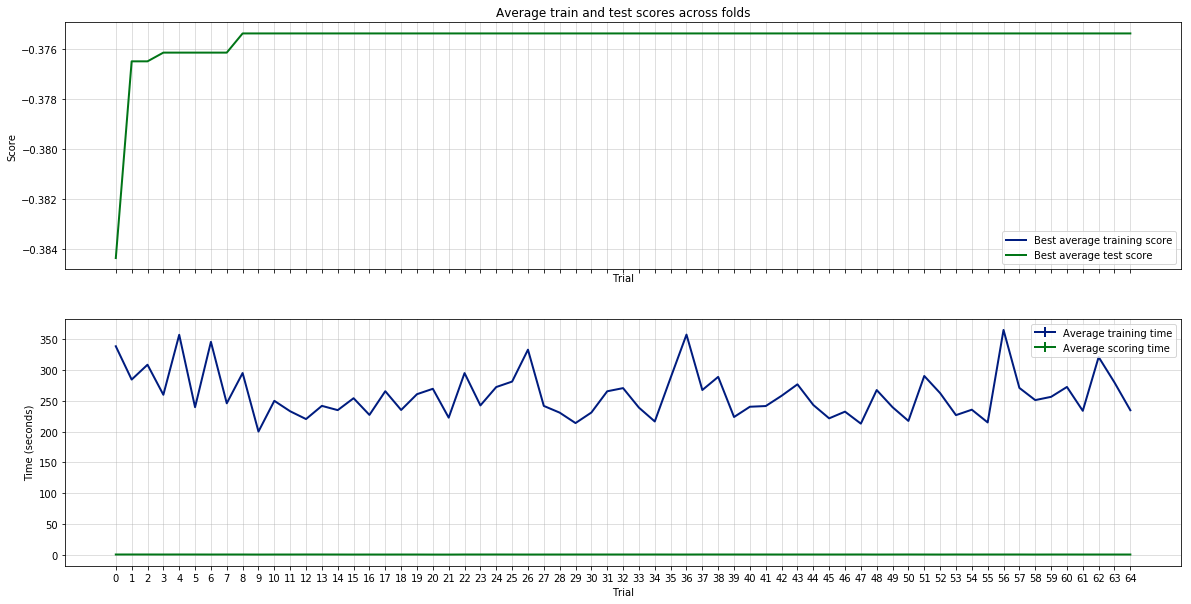

In [46]:
bayes_opt.history_.plot()

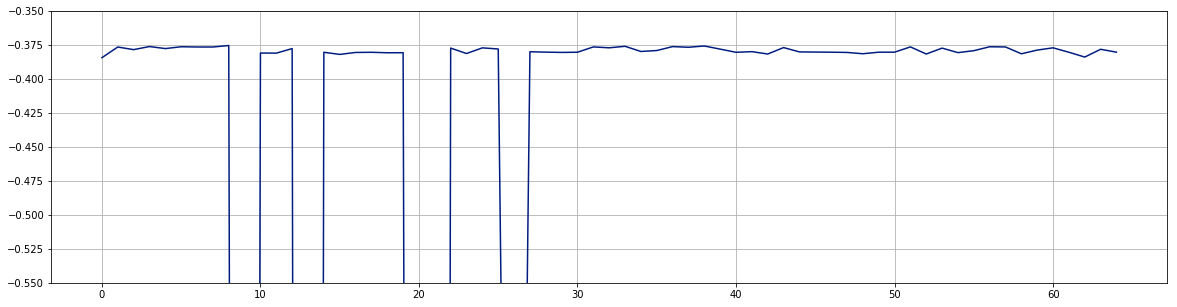

In [50]:
y = [e.test_scores[0] for e in bayes_opt.history_.entries]
f = plt.figure(figsize=(20, 5))
plt.plot(range(len(bayes_opt.history_.entries)), y)
plt.ylim(-0.55, -0.35)
plt.grid()
f

In [52]:
bayes_opt.best_test_score_

-0.37538974190856289

In [53]:
bayes_opt.best_estimator_

XGBoostEstimatorContinuous(base_score=1.6511797850819114,
              colsample_bylevel=0.96408710108715756,
              colsample_bytree=0.50000015823824073,
              gamma=2.460778740664446e-08,
              learning_rate=0.10606359242872597,
              reg_alpha=0.83477745830723182,
              reg_lambda=0.63775678184518769,
              scale_pos_weight=0.77133778314517665, subsample=1.0)

### SigOpt

In [ ]:
from hyper_optimizer import SigOptOptimizer
import time

# leave `subsample=1` as default, as we can only do 4 variables with SigOpt

sigopt_params = [p for p in params if p.name != 'subsample']
t = time.time()
sigopt_opt = SigOptOptimizer(estimator=XGBoostEstimator(), params=sigopt_params, max_trials=40, cv=(Xv, yv),
                             random_state=42, api_token='WJDDUXIXMJHTZCMEKDGWIMMAJCODKPCNLCQWALVMGCWVHQON', n_jobs=20)
sigopt_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

[0]	train-rmse:4.05677
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.260849
[99]	train-rmse:0.257002
[0]	train-rmse:4.70166
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.113761
[99]	train-rmse:0.079138
[0]	train-rmse:6.00489
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:5.31258
[99]	train-rmse:4.71231
[0]	train-rmse:5.01867
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.247466
[99]	train-rmse:0.239456
[0]	train-rmse:4.59804
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.267688
[99]	train-rmse:0.2638
[0]	train-rmse:4.46808
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.208267
[99]	train-rmse:0.202267
[0]	train-rmse:4.668
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.258267
[99]	train-rmse:0.252919
[0]	train-rmse:4.14685
Will train until train-rmse hasn't improved in 50 rounds.
[50]	tra